# Unsupervised Clustering using Hidden Markov Model 

## Import packages

In [1]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from hmmlearn import hmm
from simpl_eeg import (
    connectivity,
    eeg_objects,
    raw_voltage,
    topomap_2d,
    topomap_3d_brain,
    topomap_3d_head,
)

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
%matplotlib inline

## Why Hidden Markov Model

A Markov model assumes that the future is conditionally independent of the past given the present (Daniel & James, 2020), with the probability shown below:
$$P(S_i |S_1...S_{i−1}) = P(S_i|S_{i−1})$$ where $S_i$ is the state at time i.

A hidden Markov model (HMM) relates a sequence of observations to a sequence of hidden states that explain the observations (Daniel & James, 2020). For the EEG data, the sequence of observations is the EEG data per time frame and the sequence of hidden states would be the brain states in the dataset. Since the brain activities at time $i$ is less likely to highly correlate to brain activities before time $i-1$, the Markov model assumption would be satisfied at this case and therefore we would like to try to apply the hidden Markov model to EEG data.

Since we don't have labeled data or pre-defined brain states, we would need to use unsupervised HMM for this task. The process of finding the sequence of hidden states given the sequence of observations using HMM is called decoding (Daniel & James, 2020) and the `Viterbi` algorithm is commonly used for decoding. Therefore, for this notebook, I would use the `Viterbi` algorithm in the HMM model for finding the potential brain states. 

A hidden Markov model consists of 5 components:
- the state space: a set of hidden states
- the sequence of observation
- the transition probability matrix: the probability transitioning from state $i$ to state $j$
- the emission probabilities: conditional probabilities for all observations given a hidden state
- the initial probability over states: the probability for the Markov model starts at state $i$

The goal for this task is to explore the set of hidden states (the state space) and the transition probability matrix of the EEG data using hidden Markov model. 

## Read in the Data

In [5]:
raw_full = mne.io.read_raw_eeglab("../../data/927/fixica.set")

Reading C:\Users\Yiki\Documents\UBC\MDS\Homework\capstone\simpl_eeg_capstone\data\927\fixica.fdt


<ipython-input-5-99b5e4cf8c83>:1: RuntimeWarning: Data file name in EEG.data (927 fix ica correct.fdt) is incorrect, the file name must have changed on disk, using the correct file name (fixica.fdt).
  raw_full = mne.io.read_raw_eeglab("../../data/927/fixica.set")


In [6]:
entire_df = raw_full.to_data_frame()

In [7]:
channel_names = raw_full.ch_names

In [8]:
epoch = eeg_objects.Epochs("../../data/927").epoch

Reading C:\Users\Yiki\Documents\UBC\MDS\Homework\capstone\simpl_eeg_capstone\data\927\fixica.fdt


c:\users\yiki\documents\ubc\mds\homework\capstone\simpl_eeg_capstone\simpl_eeg\eeg_objects.py:52: RuntimeWarning: Data file name in EEG.data (927 fix ica correct.fdt) is incorrect, the file name must have changed on disk, using the correct file name (fixica.fdt).
  self.raw = mne.io.read_raw_eeglab(folder_path+"/"+file_name+".set")


Not setting metadata
Not setting metadata
33 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 33 events and 2049 original time points ...
0 bad epochs dropped


## Exploratory Data Analysis

In [9]:
entire_df.describe()

,time,Fp1,Fp2,F7,T3,T5,F3,C3,P3,Fz,Cz,Pz,F4,C4,P4,F8,T4,T6,O1,O2
count,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07,1.108849e+07
mean,2.707150e+06,-4.951856e-02,-5.360361e-02,-1.970000e-01,-1.045423e-01,-1.890660e-01,-1.007904e-01,-1.226650e-01,-1.405565e-01,-5.769371e-02,-1.050824e-01,-1.218021e-01,-6.789351e-02,-7.151982e-02,-7.599173e-02,-7.250481e-02,-4.937661e-02,-3.070300e-02,-6.297736e-02,-5.717235e-02
std,1.562974e+06,7.881340e+00,7.769932e+00,1.212798e+01,6.043827e+00,1.199746e+01,1.222635e+01,1.163743e+01,1.126299e+01,1.231525e+01,1.199590e+01,1.220014e+01,1.141870e+01,1.149002e+01,1.256943e+01,6.294935e+00,6.381905e+00,1.206392e+01,1.185191e+01,1.647667e+01
min,0.000000e+00,-8.024929e+01,-7.839950e+01,-2.722647e+02,-8.675944e+01,-2.099264e+02,-1.635053e+02,-2.136972e+02,-3.073107e+02,-1.147499e+02,-1.185257e+02,-1.350610e+02,-1.872107e+02,-1.384043e+02,-1.338534e+02,-8.942552e+01,-9.223476e+01,-2.544708e+02,-3.976269e+02,-4.125500e+02
25%,1.353575e+06,-5.059593e+00,-4.970109e+00,-7.103350e+00,-3.798762e+00,-7.367568e+00,-7.708792e+00,-7.332805e+00,-7.187517e+00,-7.874664e+00,-7.798521e+00,-7.951976e+00,-7.010767e+00,-7.186753e+00,-7.971704e+00,-3.943664e+00,-4.024702e+00,-7.243095e+00,-6.864659e+00,-7.983721e+00
50%,2.707150e+06,-1.097212e-01,-8.891173e-02,-1.409743e-01,-1.799444e-01,-3.511483e-01,-1.710321e-01,-2.296336e-01,-2.677179e-01,-9.671074e-02,-2.464668e-01,-2.721145e-01,-8.589961e-02,-7.801341e-02,-1.233626e-01,-8.700962e-02,-6.181740e-02,-9.822004e-03,-1.093020e-01,-2.175741e-01
75%,4.060726e+06,4.897449e+00,4.826879e+00,6.797164e+00,3.490998e+00,6.722553e+00,7.428260e+00,6.991313e+00,6.756059e+00,7.727930e+00,7.434458e+00,7.546031e+00,6.851805e+00,7.061900e+00,7.780638e+00,3.782850e+00,3.918500e+00,7.192153e+00,6.669391e+00,7.602581e+00
max,5.414301e+06,8.276429e+01,8.739672e+01,2.333079e+02,9.022140e+01,1.838179e+02,2.396673e+02,2.372432e+02,1.325360e+02,1.173398e+02,1.020642e+02,1.369814e+02,2.460898e+02,1.723651e+02,1.609878e+02,8.442140e+01,7.311791e+01,2.648633e+02,4.283883e+02,5.051952e+02


```python
for i in channel_names:
    dist = sns.violinplot(data=entire_df[i].values)
    dist.set_title(i)
    fig = dist.get_figure()
    filename = "img/" + i + "_dist.jpg"
    fig.savefig(filename)
```

![](img/fp1_dist.jpg) 
![](img/fp2_dist.jpg)  
![](img/f7_dist.jpg) 
![](img/t3_dist.jpg) 
![](img/t5_dist.jpg) 
![](img/f3_dist.jpg)
![](img/c3_dist.jpg) 
![](img/p3_dist.jpg)
![](img/fz_dist.jpg) 
![](img/cz_dist.jpg) 
![](img/pz_dist.jpg) 
![](img/f4_dist.jpg) 
![](img/c4_dist.jpg) 
![](img/p4_dist.jpg) 
![](img/f8_dist.jpg) 
![](img/t4_dist.jpg) 
![](img/t6_dist.jpg) 
![](img/o1_dist.jpg) 
![](img/o2_dist.jpg) 

According to the EDA, the EEG data is following Gaussian distribution for each electrode node, therefore, a GaussianHMM model would be used. However, there are clearly some outliers in the data. My next step is to remove the outliers of the data based on the expertise suggestions from the partner to keep EEG data which falls into (-50, 50) range.

## Data preprocessing

In [10]:
# drop rows where all values are zero
cleaned_df = entire_df.loc[(entire_df[channel_names] != 0).all(axis=1)]

# drop the outliers of dataset (only keep rows where EEG voltage is between -50 to 50)
df_no_outliers = cleaned_df.loc[
    ((cleaned_df[channel_names] <= 50) & (cleaned_df[channel_names] >= -50)).all(axis=1)
]

# chunk the data into per second (each second has 2048 readings (rows))
df_second = np.split(df_no_outliers, range(2048, len(df_no_outliers), 2048))


# for each second, randomly sampled 10 time stamps (the original dataset is too big, wants to sample a smaller dataset for exploration)
df_second_resample = {}
for second in range(len(df_second)):
    df_second_resample[second] = (
        df_second[second].sample(10, random_state=2020, axis=0).sort_values(by="time")
    )
df_resampled = pd.concat([values for key, values in df_second_resample.items()])

## Building Models

Based on the suggestion from the partner, we would like to explore the data in per 5 second interval. 

In [11]:
five_second_df = np.split(df_resampled, range(50, len(df_resampled), 50))

In [12]:
# since HMM model only takes in (n_sample, n_feature) array, reshape the data into an array where each sample has 50 time stamps (5 seconds data)
chunked_list = []
for i in range(len(five_second_df)):
    chunked_list.append(np.array(five_second_df[i].iloc[:, 1:]).flatten())
chunked_array = np.array(chunked_list)

As mentioned above, the EEG data follows Gaussian distribution and is continous, we would use the `GaussianHMM` model from `hmmlearn` package. Since we don't know the number of brain states from the model, we would like to start with some random numbers.

In [58]:
# n_components is the number of hidden states (number of brain states)
chunked_model = hmm.GaussianHMM(n_components=8)

In [59]:
chunked_model.fit(chunked_array)

GaussianHMM(n_components=8)

In [60]:
chunked_result = chunked_model.decode(chunked_array, algorithm="viterbi")

### Check model output

In [61]:
# the metric that hmmlearn package itself used to evaluate the model
print(
    f"The log probability for this {chunked_model.n_components}-cluster model is {chunked_result[0]:0.4f}"
)

The log probability for this 8-cluster model is -3650880.0252


In [62]:
print(f"The prior probability for this model is: {chunked_model.startprob_}")

The prior probability for this model is: [1.84257816e-33 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


In [63]:
print(
    f"The transmission probability matrix of this model is: \n {chunked_model.transmat_}"
)

The transmission probability matrix of this model is: 
 [[0.17311702 0.09011855 0.15891525 0.07423119 0.10599415 0.17469578
  0.1169318  0.10599626]
 [0.26920465 0.11539271 0.099992   0.09230184 0.13076136 0.13846638
  0.07697457 0.0769065 ]
 [0.14450008 0.13725553 0.17650583 0.05779823 0.09392541 0.09393205
  0.14435578 0.1517271 ]
 [0.18577814 0.06866836 0.09939395 0.0882879  0.15695622 0.12752789
  0.12752707 0.14586047]
 [0.15971453 0.13445904 0.17647144 0.14235001 0.08403024 0.10077491
  0.14337354 0.05882629]
 [0.17395075 0.15218418 0.08696908 0.1086616  0.07972311 0.13759902
  0.1304545  0.13045775]
 [0.18678299 0.18626412 0.10159817 0.05926567 0.14392973 0.1358935
  0.08466771 0.10159811]
 [0.14438897 0.11034121 0.1260623  0.16968614 0.12726205 0.11864537
  0.06787357 0.13574039]]


In [64]:
# add lables back to the df
df_result = five_second_df.copy()
for i in range(len(df_result)):
    df_result[i] = df_result[i].assign(cluster=chunked_result[1][i])

In [65]:
df_result = pd.concat([df_result[i] for i in range(len(df_result))])

In [66]:
df_result.head()

,time,Fp1,Fp2,F7,T3,T5,F3,C3,P3,Fz,...,Pz,F4,C4,P4,F8,T4,T6,O1,O2,cluster
290,142,-12.305924,-14.524019,-12.033823,-10.463505,-18.698639,-21.039619,-17.012308,-9.173825,-20.733271,...,-10.324389,-21.066496,-10.429639,-12.290789,-7.048176,-13.812033,-30.080774,-9.132559,-24.478706,2
835,408,2.043821,0.677582,4.069639,0.183605,-1.415403,0.921270,0.454749,-2.289015,0.769230,...,4.335721,-3.216433,1.440984,13.561232,0.889752,2.896240,12.884544,4.252829,15.347451,2
951,464,-1.345173,-3.076103,-1.363036,-5.552776,-14.956915,-8.253411,-7.443714,-7.266998,-3.748096,...,-4.303961,-3.743513,-4.067729,-0.489298,-3.749812,-2.437128,4.650862,-2.279960,7.630559,2
1077,526,-1.204437,-1.127121,4.215368,-0.593124,-5.474500,1.049892,-7.793763,-11.830889,0.610142,...,-9.682485,2.152258,-5.578439,-0.699790,-1.290700,-1.334474,0.059585,0.868291,0.214049,2
1079,527,1.416702,1.575619,11.799867,0.300454,-8.435659,0.702340,-2.704662,-11.066032,1.391591,...,-2.896578,4.693271,0.308687,8.091104,0.271600,3.730724,14.582500,4.444334,14.589820,2


### Visualize output

#### Visualize the average voltage for each cluster

In [67]:
cluster_dict = {}
for i in range(chunked_model.n_components):
    cluster_dict["cluster_" + str(i)] = df_result[df_result["cluster"] == i]

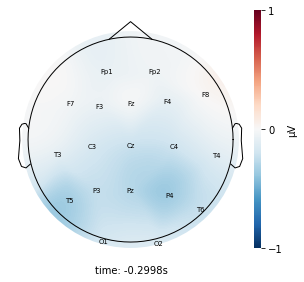

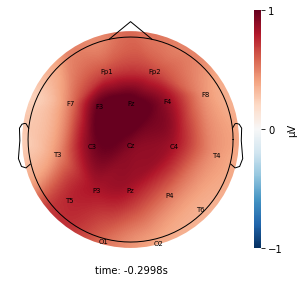

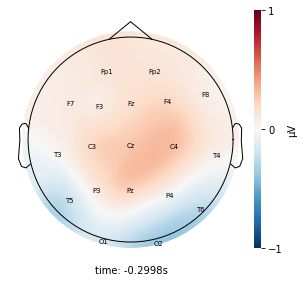

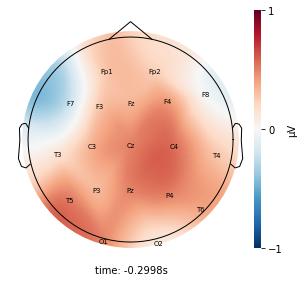

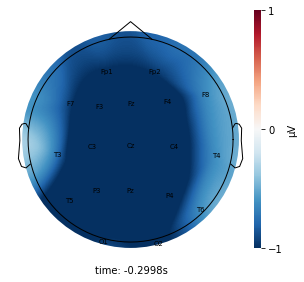

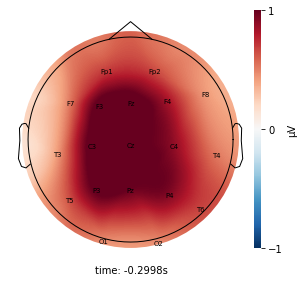

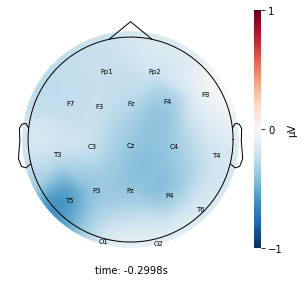

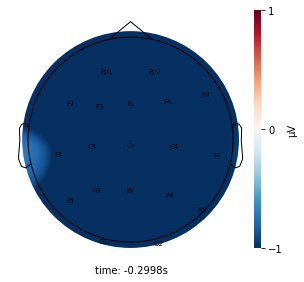

In [69]:
for cluster_key, cluster in cluster_dict.items():
    cluster_key = topomap_2d.plot_topomap_2d(
        epoch,
        cluster.iloc[:, 1:20].mean().values * 1e-6,
        mark="channel_name",
        cmin=-1,
        cmax=1,
    )

#### Visualize in an animated way

In [ ]:
cluster_array = np.array(df_result.cluster)
change_index = np.where(cluster_array[:-1] != cluster_array[1:])[0]

In [ ]:
first_batch = df_result.iloc[: change_index[0] + 1]

In [ ]:
%%capture
ani_cluster3 = topomap_2d.animate_topomap_2d(
    epoch, (first_batch.iloc[:, 1:20].to_numpy().T) * 1e-6, frame_rate=4
)
from IPython.core.display import HTML

video_cluster3 = HTML(ani_cluster3.to_jshtml())

In [ ]:
video_cluster3

In [ ]:
second_batch = df_result.iloc[change_index[0] + 1 : change_index[1] + 1]

In [ ]:
%%capture
ani_cluster0 = topomap_2d.animate_topomap_2d(
    epoch, (second_batch.iloc[:, 1:20].to_numpy().T) * 1e-6, frame_rate=4
)
from IPython.core.display import HTML

video_cluster0 = HTML(ani_cluster0.to_jshtml())

In [ ]:
video_cluster0

In [ ]:
#### Check the time stamp when a change occurs
topomap_2d.plot_topomap_2d(
    epoch,
    (df_result.iloc[change_index[19], 1:20].values) * 1e-6,
    mark="channel_name",
    cmin=-30,
    cmax=30,
)

#### Label the original dataset and visualize the outcome

In [ ]:
# add lables back to the entire_df
entire_df_result = df_second.copy()
for i in range(len(entire_df_result)):
    entire_df_result[i] = entire_df_result[i].assign(cluster=chunked_result[1][i])

In [ ]:
entire_df_result = pd.concat(
    [entire_df_result[i] for i in range(len(entire_df_result))]
)

In [ ]:
entire_cluster_dict = {}
for i in range(chunked_model.n_components):
    entire_cluster_dict["cluster_" + str(i)] = entire_df_result[
        entire_df_result["cluster"] == i
    ]

## Next Steps

Due to the limited time and efforts that we could allocate to this task, there are other potential useful approaches to try for this task but haven't been implemented yet. 

- Data preprocessing: instead of sampling only 10 time stamps per second, increase the sampling rate so that it could capture more dynmaics from each second to provide a more accurate resutl.

- Feature engineering: instead of only using the raw voltage data for model input, include some engineered features that could provide a better representation of the temporal dependencies of the data such as the following:
    - apply rolling mean for each 5 second data chunks rather than simply taking the mean of each 5 second data chunks
    - use the sliding window approach to slide the per 5 second data 


- Literature review: read through more literature articles to define a better metric to evaluate the model

- Hyperparameter tuning: currently, there isn't a better way to find the optimal `# of cluster` in the model other than finish fitting the model and visualizing the output to check. Use the metric that we could locate from the previous objective to tune the hyperparameter.

## Attribution

- Speech and Language Processing. Daniel Jurafsky & James H. Martin. Copyright © 2020. All
rights reserved. Draft of December 30, 2020.
